In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from statsmodels.formula.api import ols

# Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)
temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [3]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [4]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)
disaster_df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [5]:
disaster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46185 entries, 0 to 46184
Data columns (total 14 columns):
Declaration Number                  46185 non-null object
Declaration Type                    46185 non-null object
Declaration Date                    46185 non-null object
State                               46185 non-null object
County                              45988 non-null object
Disaster Type                       46185 non-null object
Disaster Title                      46185 non-null object
Start Date                          46185 non-null object
End Date                            45843 non-null object
Close Date                          35210 non-null object
Individual Assistance Program       46185 non-null object
Individuals & Households Program    46185 non-null object
Public Assistance Program           46185 non-null object
Hazard Mitigation Program           46185 non-null object
dtypes: object(14)
memory usage: 4.9+ MB


In [6]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)
us_join.head()

,zip_code,latitude,longitude,city,state,county
0,501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,602,18.393103,-67.180953,Aguada,PR,Aguada
4,603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [7]:
us_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42741 entries, 0 to 42740
Data columns (total 6 columns):
zip_code     42741 non-null int64
latitude     42049 non-null float64
longitude    42049 non-null float64
city         42741 non-null object
state        42741 non-null object
county       42199 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


# Cleaning steps

In [8]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [9]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [10]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [11]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [12]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [13]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])

In [14]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [15]:
temp_county['dt'] = pd.to_datetime(temp_county['dt'], format='%Y/%m/%d')
temp_county['year'] = temp_county['dt'].dt.year

In [16]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820


In [17]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = temp_county_seasons['dt'].dt.month

In [18]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [19]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


In [20]:
# map the region onto each of the states
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)

## Join temperature and disaster

In [21]:
# temperature df with the county names 
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,1,Winter,west south central south region
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,2,Winter,west south central south region
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,3,Spring,west south central south region
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,4,Spring,west south central south region
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,5,Spring,west south central south region


In [22]:
# disaster data - create year column
disasterdf = disaster_df.copy()
disasterdf['Declaration Date'] = pd.to_datetime(disasterdf['Declaration Date'], format='%m/%d/%Y')
disasterdf['Year'] = disasterdf['Declaration Date'].dt.year

# create region column
disasterdf['Region'] = disasterdf['State'].map(d)

# select columns for merge 
disasterdf = disasterdf[['Declaration Type','Declaration Date','State','County','Disaster Type','Year','Region']]


In [23]:
# disaster data - delete duplicate listing of disasters on the same day (ie. unique disaster per day per state)
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date','Disaster Type','State','Year']).sort_values('Declaration Date')


In [24]:
# determine top 5 most common disaster types
disasterdf['Disaster Type'].value_counts().head()

Storm        919
Flood        772
Fire         680
Hurricane    313
Tornado      163
Name: Disaster Type, dtype: int64

In [25]:
# select top 5 disasters
disasterdf = disasterdf[disasterdf['Disaster Type'].isin(['Tornado','Flood','Fire','Hurricane','Storm'])]

# create new disaster count column 
disasterdf['Disaster Count'] = disasterdf['Disaster Type']

In [26]:
# disaster data groupby, get disaster count by region, disaster type, and year
disasterdf = disasterdf.groupby(['Region','Disaster Type','Year'])[['Disaster Count']].count().unstack(fill_value=0).stack().reset_index()

In [27]:
# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf = tempdf.sort_values('dt')

In [28]:
# select columns for join
tempdf = tempdf[['year','AverageTemperature','season','region']]

In [29]:
# temperature data - feature engineer temperature by region and year
tempdf = tempdf.groupby(['region','year']).agg({'AverageTemperature': ['mean','min','max','std']}).unstack(fill_value=0).stack().reset_index()
tempdf.columns = ["_".join(x) for x in tempdf.columns.ravel()]

In [30]:
# rename columns in temperature data frame
tempdf = tempdf.rename(columns={"region_": "region", "year_": "year"});

In [31]:
# create dataframe for seasonal temperature by year and region
season = temp_county_region.pivot_table('AverageTemperature', index=['year','region'], columns='season', fill_value='NaN').reset_index()


In [32]:
# join the temperature dataframe with the seasonal temperatures to obtain more features
join_dataframe = pd.merge(tempdf, season, left_on=['region','year'], right_on=['region','year'], how='left')

In [33]:
# join temperature and disaster dataframe 
joindf = pd.merge(disasterdf, join_dataframe, left_on=['Region','Year'], right_on=['region','year'], how='left')

In [34]:
# drop duplicate columns; drop 2013 since it does not contain a full year of data
joindf = joindf.drop(columns = ['region','year'])
joindf = joindf[joindf['Year']<= 2012]

In [35]:
pd.set_option('display.max_columns', 500)
joindf.tail()

,Region,Disaster Type,Year,Disaster Count,AverageTemperature_mean,AverageTemperature_min,AverageTemperature_max,AverageTemperature_std,Fall,Spring,Summer,Winter
2850,west south central south region,Tornado,2008,0,19.052245,3.053,30.693,7.579754,19.1908,18.9916,28.3269,9.69968
2851,west south central south region,Tornado,2009,1,19.102935,1.064,32.232,7.769587,19.156,18.9752,28.701,9.57956
2852,west south central south region,Tornado,2010,0,18.925417,0.836,31.432,8.673479,20.2207,18.6802,29.2255,7.57517
2853,west south central south region,Tornado,2011,0,19.969954,1.069,33.778,8.732722,20.0492,20.2621,30.9306,8.63786
2854,west south central south region,Tornado,2012,0,20.344891,5.253,31.476,7.161696,20,21.3145,28.8652,11.1998


In [36]:
joindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 0 to 2854
Data columns (total 12 columns):
Region                     2640 non-null object
Disaster Type              2640 non-null object
Year                       2640 non-null int64
Disaster Count             2640 non-null int64
AverageTemperature_mean    2640 non-null float64
AverageTemperature_min     2640 non-null float64
AverageTemperature_max     2640 non-null float64
AverageTemperature_std     2640 non-null float64
Fall                       2640 non-null object
Spring                     2640 non-null object
Summer                     2640 non-null object
Winter                     2640 non-null object
dtypes: float64(4), int64(2), object(6)
memory usage: 268.1+ KB


## Exploring the Data

#### The core question is: 
How does temperature change affect the other natural processes in the world? More specifically, how are natural disasters changing, due to global warming?

### Average yearly temperature, sorted by state

Text(0,0.5,'Temperature (in degrees Celsius)')

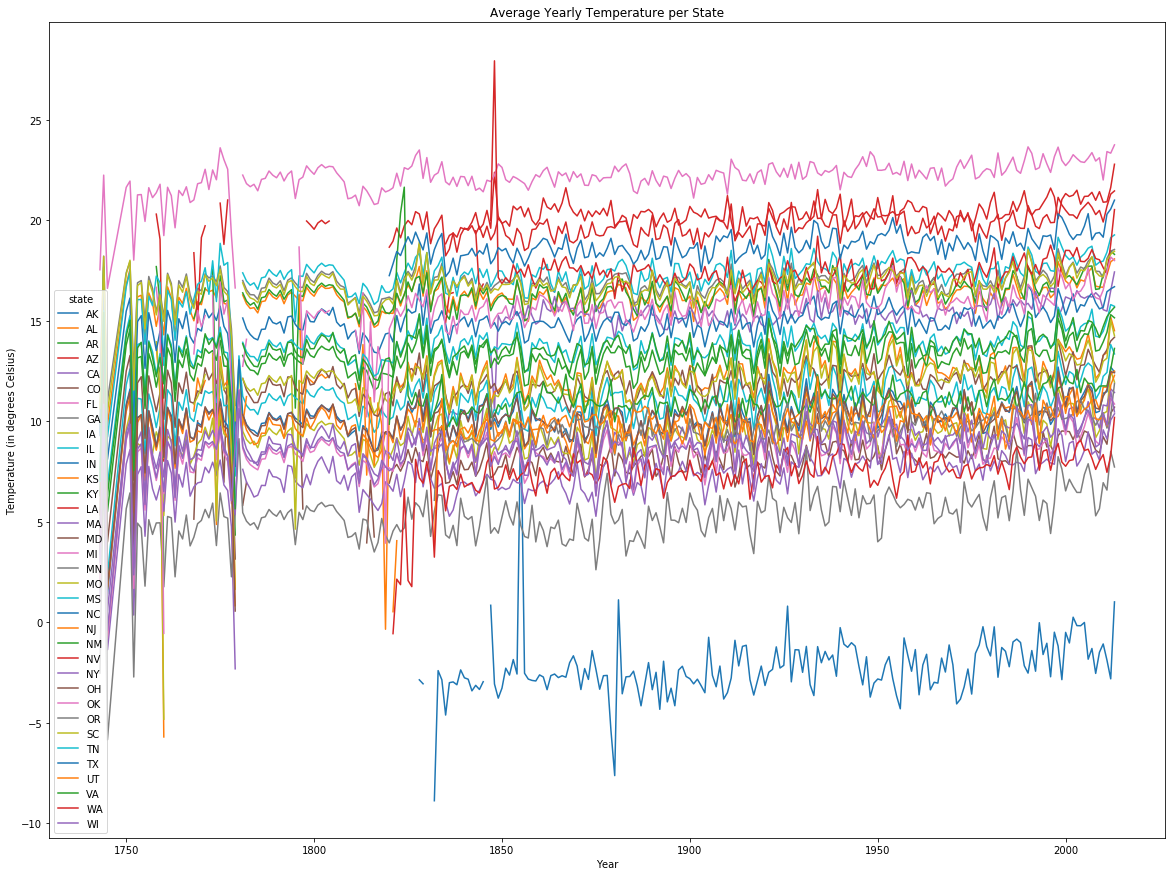

In [37]:
# plot data: average yearly temperature by state
fig, ax = plt.subplots(figsize=(20,15))
temp_county_region.groupby(['year','state']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average Yearly Temperature per State')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')

### Average yearly temperature, from the earliest fully recorded year to the most recent

In [38]:
# looking for the earliest year that contains the same count as the most recent year (257)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(temp_county_seasons.groupby(['dt']).count()[['AverageTemperature']].head())

            AverageTemperature
dt                            
1743-11-01                  98
1744-04-01                  98
1744-05-01                  98
1744-06-01                  98
1744-07-01                  98


Text(0,0.5,'Temperature (in degrees Celsius)')

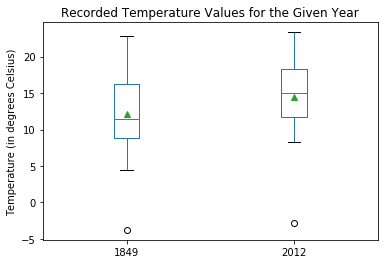

In [39]:
# create a dataframe with the subset of the years 1849 and 2012
subset = temp_county_seasons.copy()
subset = subset.groupby(['state','year']).mean()['AverageTemperature'].unstack().reset_index()
subset = subset[[1849,2012]]
subset[[1849,2012]].plot(kind='box', title='Recorded Temperature Values for the Given Year',showmeans=True)
plt.ylabel('Temperature (in degrees Celsius)')


### Average yearly temperature, sorted by region

In [40]:
# create a 1849 and 2012 subset of data for each region to compare boxplot for the years
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'][['year','AverageTemperature']]
enc_1849 = enc_midwest_region[enc_midwest_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
enc_2012 = enc_midwest_region[enc_midwest_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'][['year','AverageTemperature']]
esc_1849 = esc_south_region[esc_south_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
esc_2012 = esc_south_region[esc_south_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'][['year','AverageTemperature']]
mid_1849 = mid_northeast_region[mid_northeast_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
mid_2012 = mid_northeast_region[mid_northeast_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'][['year','AverageTemperature']]
mt_1849 = mt_west_region[mt_west_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
mt_2012 = mt_west_region[mt_west_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'][['year','AverageTemperature']]
ne_1849 = ne_northeast_region[ne_northeast_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
ne_2012 = ne_northeast_region[ne_northeast_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'][['year','AverageTemperature']]
pac_1849 = pac_west_region[pac_west_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
pac_2012 = pac_west_region[pac_west_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'][['year','AverageTemperature']]
sa_1849 = sa_south_region[sa_south_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
sa_2012 = sa_south_region[sa_south_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'][['year','AverageTemperature']]
wnc_1849 = wnc_midwest_region[wnc_midwest_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
wnc_2012 = wnc_midwest_region[wnc_midwest_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'][['year','AverageTemperature']]
wsc_1849 = wsc_south_region[wsc_south_region['year']==1849].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
wsc_2012 = wsc_south_region[wsc_south_region['year']==2012].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



Text(0.5,1,'West South Central')

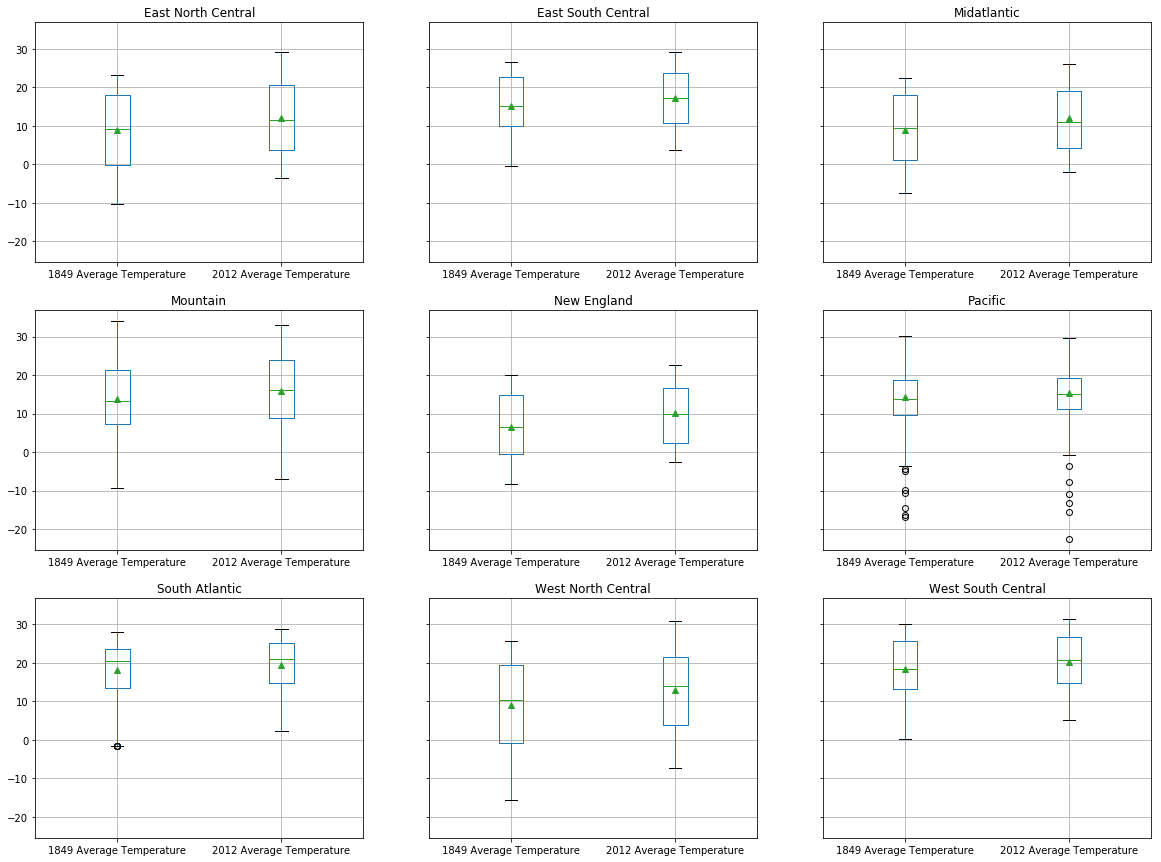

In [41]:
# boxplot of each region and the two years in comparison
fig, ax = plt.subplots(3,3, sharey='all',figsize=(20,15))

enc = pd.concat([enc_1849,enc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
enc.boxplot(ax=ax[0,0], showmeans=True)
ax[0,0].set_title('East North Central')

esc = pd.concat([esc_1849,esc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
esc.boxplot(ax=ax[0,1], showmeans=True)
ax[0,1].set_title('East South Central')

mid = pd.concat([mid_1849,mid_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
mid.boxplot(ax=ax[0,2], showmeans=True)
ax[0,2].set_title('Midatlantic')

mt = pd.concat([mt_1849,mt_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
mt.boxplot(ax=ax[1,0], showmeans=True)
ax[1,0].set_title('Mountain')

ne = pd.concat([ne_1849,ne_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
ne.boxplot(ax=ax[1,1], showmeans=True)
ax[1,1].set_title('New England')

pac = pd.concat([pac_1849,pac_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
pac.boxplot(ax=ax[1,2], showmeans=True)
ax[1,2].set_title('Pacific')

sa = pd.concat([sa_1849,sa_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
sa.boxplot(ax=ax[2,0], showmeans=True)
ax[2,0].set_title('South Atlantic')

wnc = pd.concat([wnc_1849,wnc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
wnc.boxplot(ax=ax[2,1], showmeans=True)
ax[2,1].set_title('West North Central')

wsc = pd.concat([wsc_1849,wsc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
wsc.boxplot(ax=ax[2,2], showmeans=True)
ax[2,2].set_title('West South Central')


### Average yearly temperature, sorted by season

In [42]:
# create a dataframe for seasons
seasons_df = temp_county_region.copy()
seasons_df = seasons_df[['season','state','region','year','AverageTemperature']]
seasons_df = seasons_df.groupby(['season','year']).mean().unstack('season')


Text(0,0.5,'Temperature (in degrees Celsius)')

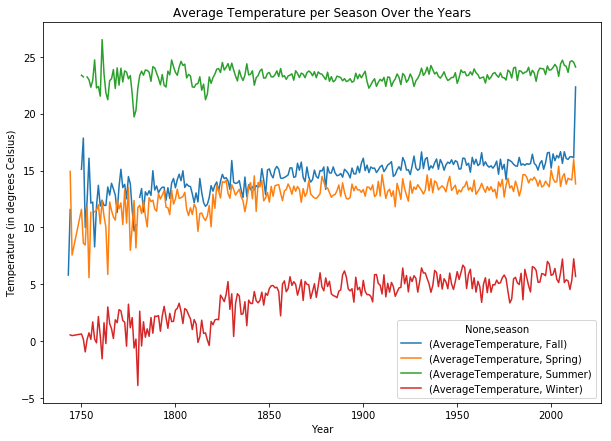

In [43]:
# temperature over time by season
fig, ax = plt.subplots(figsize=(10,7))
seasons_df.plot(ax=ax)
plt.title('Average Temperature per Season Over the Years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')

Text(0,0.5,'Temperature (in degrees Celsius)')

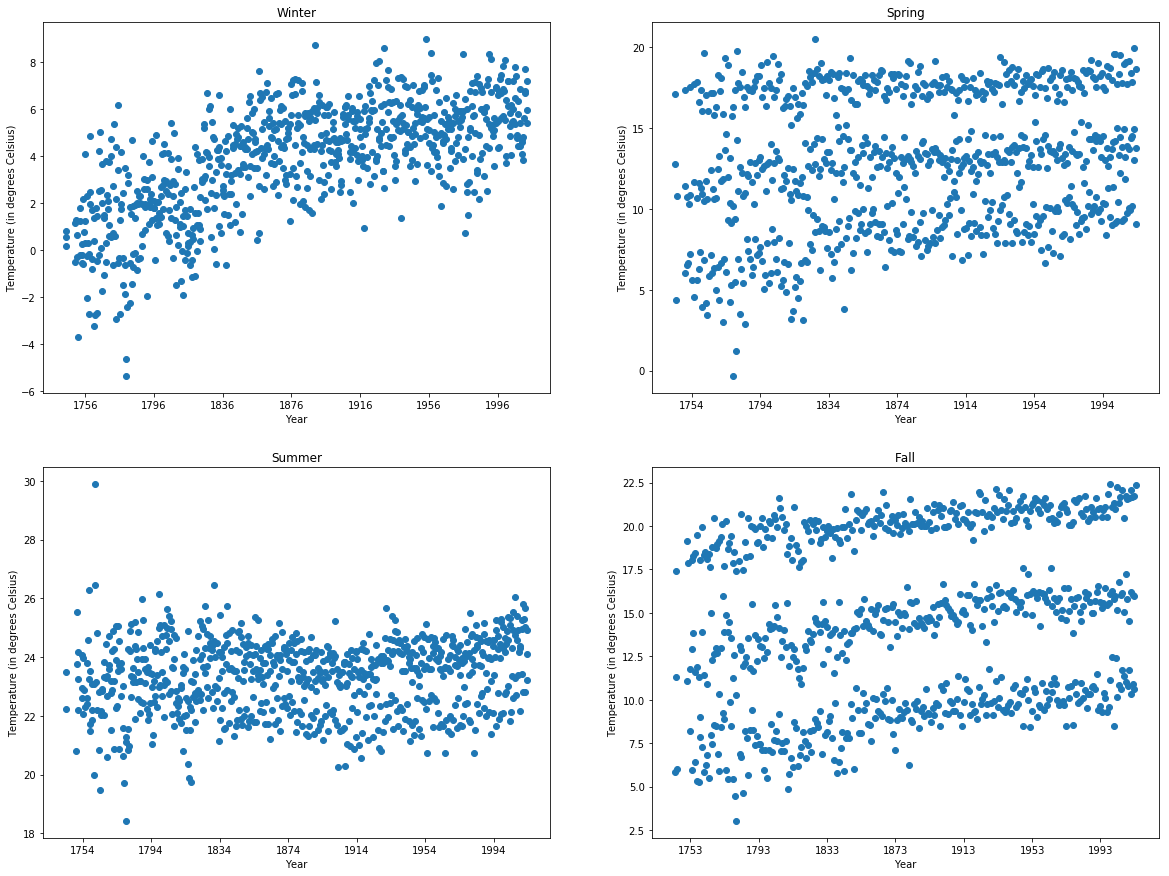

In [44]:
# average yearly temperature per season
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby('dt').mean()[['AverageTemperature']].reset_index()
winter['date'] = winter['dt'].astype('datetime64[ns]')
ax[0,0].scatter(winter['date'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')   
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Temperature (in degrees Celsius)')
           
spring = temp_county_region[temp_county_region.season == 'Spring'].groupby('dt').mean()[['AverageTemperature']].reset_index()
spring['date'] = spring['dt'].astype('datetime64[ns]')
ax[0,1].scatter(spring['date'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Temperature (in degrees Celsius)')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby('dt').mean()[['AverageTemperature']].reset_index()
summer['date'] = summer['dt'].astype('datetime64[ns]')
ax[1,0].scatter(summer['date'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Temperature (in degrees Celsius)')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby('dt').mean()[['AverageTemperature']].reset_index()
fall['date'] = fall['dt'].astype('datetime64[ns]')
ax[1,1].scatter(fall['date'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')  
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Temperature (in degrees Celsius)')
           

### Average yearly temperature, sorted by month

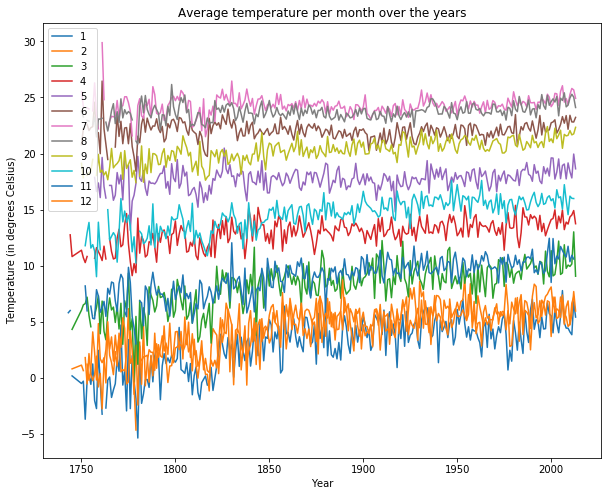

In [45]:
# temperature over time by month
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','month']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per month over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

Text(0,0.5,'Temperature (in degrees Celsius)')

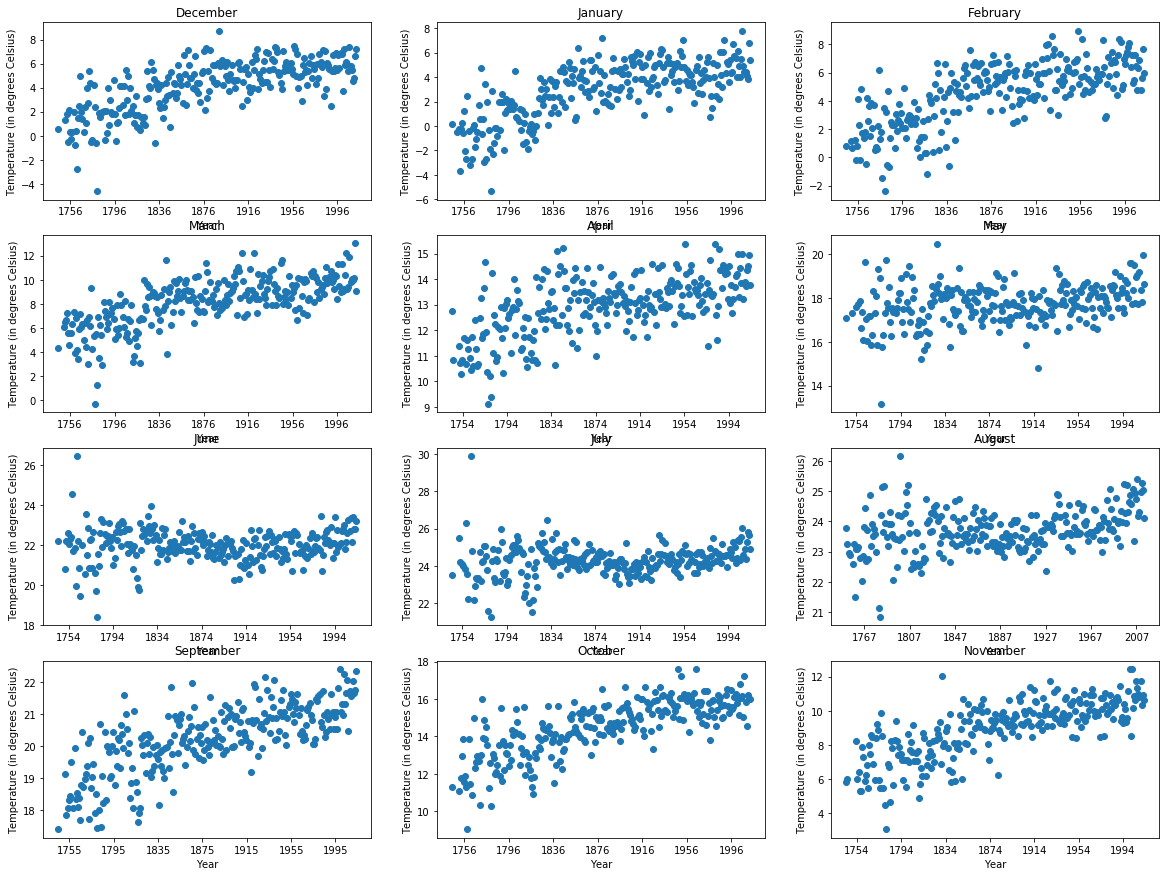

In [46]:
# average yearly temperature per month
fig, ax = plt.subplots(4,3,figsize=(20,15))

dec = temp_county_region[temp_county_region.month == 12].groupby('dt').mean()[['AverageTemperature']].reset_index()
dec['date'] = dec['dt'].astype('datetime64[ns]')
ax[0,0].scatter(dec['date'].tolist() ,dec['AverageTemperature'].tolist())
ax[0,0].set_title('December')    
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Temperature (in degrees Celsius)')
                    
jan = temp_county_region[temp_county_region.month == 1].groupby('dt').mean()[['AverageTemperature']].reset_index()
jan['date'] = jan['dt'].astype('datetime64[ns]')
ax[0,1].scatter(jan['date'].tolist() ,jan['AverageTemperature'].tolist())
ax[0,1].set_title('January')       
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Temperature (in degrees Celsius)')

feb = temp_county_region[temp_county_region.month == 2].groupby('dt').mean()[['AverageTemperature']].reset_index()
feb['date'] = feb['dt'].astype('datetime64[ns]')
ax[0,2].scatter(feb['date'].tolist() ,feb['AverageTemperature'].tolist())
ax[0,2].set_title('February')       
ax[0,2].set_xlabel('Year')
ax[0,2].set_ylabel('Temperature (in degrees Celsius)')


mar = temp_county_region[temp_county_region.month == 3].groupby('dt').mean()[['AverageTemperature']].reset_index()
mar['date'] = mar['dt'].astype('datetime64[ns]')
ax[1,0].scatter(mar['date'].tolist() ,mar['AverageTemperature'].tolist())
ax[1,0].set_title('March')           
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Temperature (in degrees Celsius)')
                    
apr = temp_county_region[temp_county_region.month == 4].groupby('dt').mean()[['AverageTemperature']].reset_index()
apr['date'] = apr['dt'].astype('datetime64[ns]')
ax[1,1].scatter(apr['date'].tolist() ,apr['AverageTemperature'].tolist())
ax[1,1].set_title('April')       
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Temperature (in degrees Celsius)')

may = temp_county_region[temp_county_region.month == 5].groupby('dt').mean()[['AverageTemperature']].reset_index()
may['date'] = may['dt'].astype('datetime64[ns]')
ax[1,2].scatter(may['date'].tolist() ,may['AverageTemperature'].tolist())
ax[1,2].set_title('May')
ax[1,2].set_xlabel('Year')
ax[1,2].set_ylabel('Temperature (in degrees Celsius)')


jun = temp_county_region[temp_county_region.month == 6].groupby('dt').mean()[['AverageTemperature']].reset_index()
jun['date'] = jun['dt'].astype('datetime64[ns]')
ax[2,0].scatter(jun['date'].tolist() ,jun['AverageTemperature'].tolist())
ax[2,0].set_title('June')           
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Temperature (in degrees Celsius)')
                    
jul = temp_county_region[temp_county_region.month == 7].groupby('dt').mean()[['AverageTemperature']].reset_index()
jul['date'] = jul['dt'].astype('datetime64[ns]')
ax[2,1].scatter(jul['date'].tolist() ,jul['AverageTemperature'].tolist())
ax[2,1].set_title('July')       
ax[2,1].set_xlabel('Year')
ax[2,1].set_ylabel('Temperature (in degrees Celsius)')

aug = temp_county_region[temp_county_region.month == 8].groupby('dt').mean()[['AverageTemperature']].reset_index()
aug['date'] = aug['dt'].astype('datetime64[ns]')
ax[2,2].scatter(aug['date'].tolist() ,aug['AverageTemperature'].tolist())
ax[2,2].set_title('August')
ax[2,2].set_xlabel('Year')
ax[2,2].set_ylabel('Temperature (in degrees Celsius)')


sep = temp_county_region[temp_county_region.month == 9].groupby('dt').mean()[['AverageTemperature']].reset_index()
sep['date'] = sep['dt'].astype('datetime64[ns]')
ax[3,0].scatter(sep['date'].tolist() ,sep['AverageTemperature'].tolist())
ax[3,0].set_title('September')
ax[3,0].set_xlabel('Year')
ax[3,0].set_ylabel('Temperature (in degrees Celsius)')
                    
octo = temp_county_region[temp_county_region.month == 10].groupby('dt').mean()[['AverageTemperature']].reset_index()
octo['date'] = octo['dt'].astype('datetime64[ns]')
ax[3,1].scatter(octo['date'].tolist() ,octo['AverageTemperature'].tolist())
ax[3,1].set_title('October')    
ax[3,1].set_xlabel('Year')
ax[3,1].set_ylabel('Temperature (in degrees Celsius)')

nov = temp_county_region[temp_county_region.month == 11].groupby('dt').mean()[['AverageTemperature']].reset_index()
nov['date'] = nov['dt'].astype('datetime64[ns]')
ax[3,2].scatter(nov['date'].tolist() ,nov['AverageTemperature'].tolist())
ax[3,2].set_title('November')
ax[3,2].set_xlabel('Year')
ax[3,2].set_ylabel('Temperature (in degrees Celsius)')

### Joined data

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

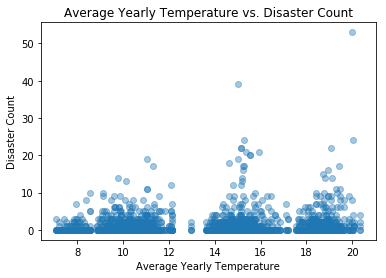

In [47]:
# plot of all disaster counts vs the average mean temperature
plt.scatter(joindf['AverageTemperature_mean'], joindf['Disaster Count'], alpha=0.4)
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Storms

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

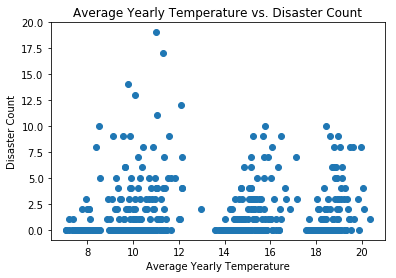

In [48]:
# disaster count vs average mean temperature for storms
stormdf = joindf[joindf['Disaster Type']=='Storm']

plt.scatter(stormdf['AverageTemperature_mean'], stormdf['Disaster Count'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Floods

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

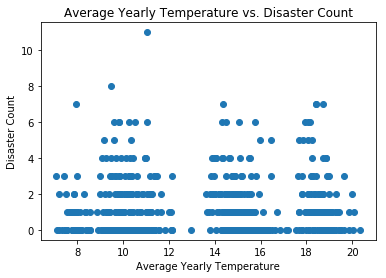

In [49]:
# disaster count vs average mean temperature for floods
flooddf = joindf[(joindf['Disaster Type']=='Flood')]

plt.scatter(flooddf['AverageTemperature_mean'], flooddf['Disaster Count'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Fires

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

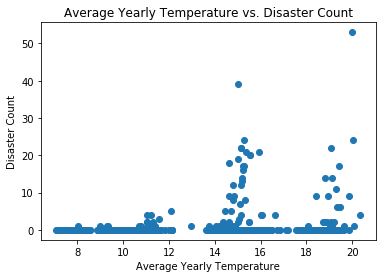

In [50]:
# disaster count vs average mean temperature for fires
firedf = joindf[(joindf['Disaster Type']=='Fire')]

plt.scatter(firedf['AverageTemperature_mean'], firedf['Disaster Count'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Hurricanes

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

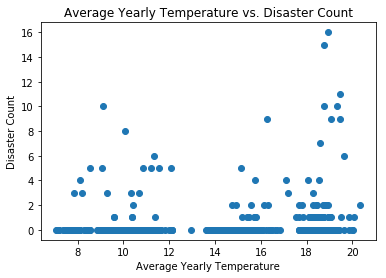

In [51]:
# disaster count vs average mean temperature for hurricanes
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')]

plt.scatter(hurricanedf['AverageTemperature_mean'], hurricanedf['Disaster Count'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Tornados 

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

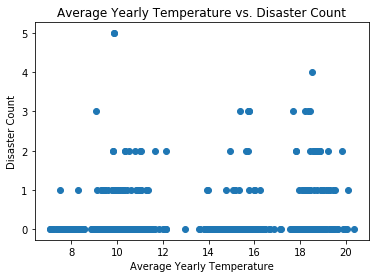

In [52]:
# disaster count vs average mean temperature for tornados
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')]

plt.scatter(tornadodf['AverageTemperature_mean'], tornadodf['Disaster Count'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

# Statistical Inference

## Average yearly temperature, sorted by season

Text(0,0.5,'Temperature (in degrees Celsius)')

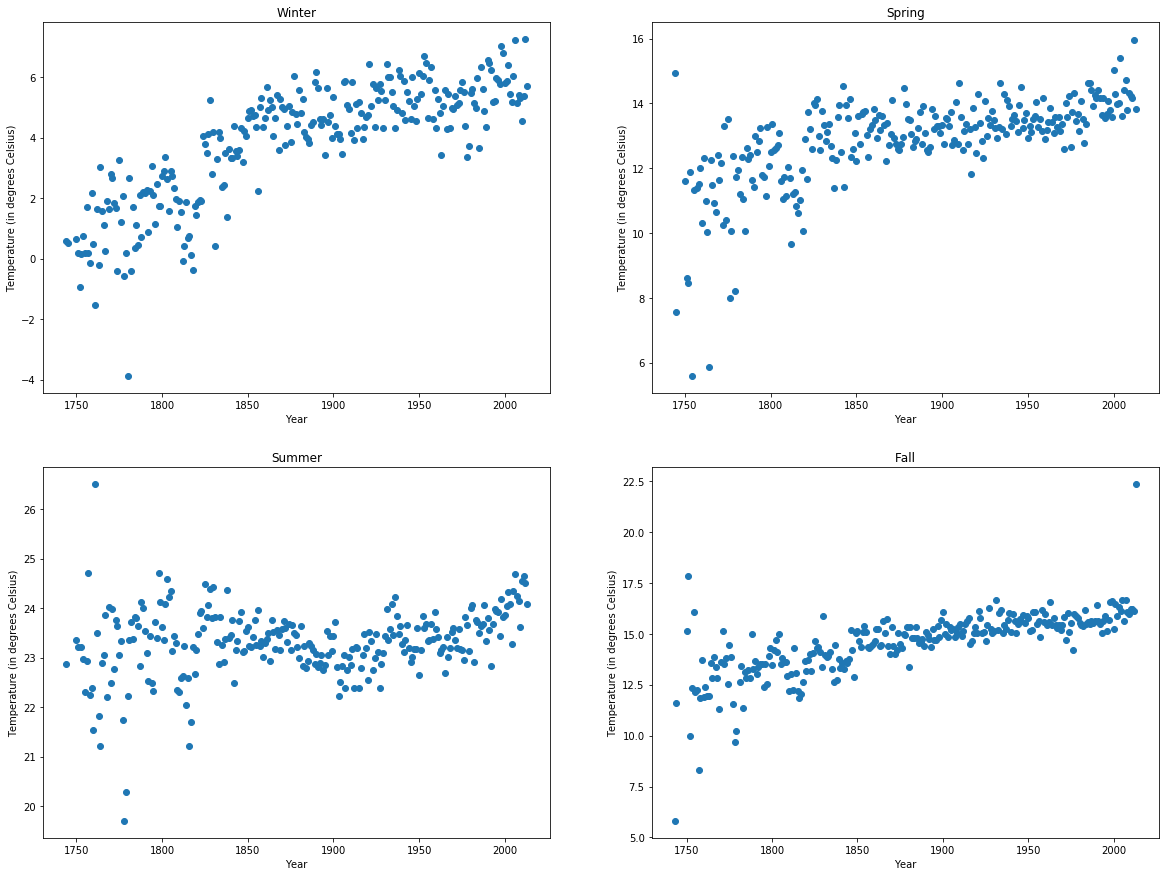

In [53]:
# average yearly temperature per season (sorted by year)
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,0].scatter(winter['year'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Temperature (in degrees Celsius)')

spring = temp_county_region[temp_county_region.season == 'Spring'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,1].scatter(spring['year'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Temperature (in degrees Celsius)')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,0].scatter(summer['year'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Temperature (in degrees Celsius)')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,1].scatter(fall['year'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')           
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Temperature (in degrees Celsius)')                   
           

In [54]:
# correlation between year and average temperature for each of the seasons
print('winter corr: ', winter['year'].corr(winter.AverageTemperature),'\n'
      'spring corr: ', spring['year'].corr(spring.AverageTemperature),'\n'
      'summer corr: ', summer['year'].corr(summer.AverageTemperature),'\n'
      'fall corr  : ', fall['year'].corr(fall.AverageTemperature))

winter corr:  0.8185691856309464 
spring corr:  0.6587791341045452 
summer corr:  0.24555088282850218 
fall corr  :  0.7381441619175758


### Winter Linear Regression

In [55]:
# set the variables to time and temperature for the winter
x = winter[['year']].values
y = winter[['AverageTemperature']].values

In [56]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.020839    intercept: -35.340342    r-squared: 0.670056    p-value: 0.000000


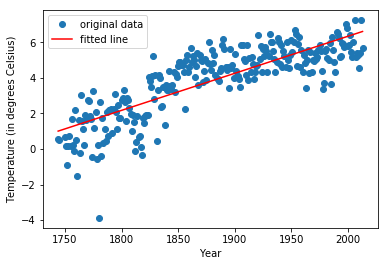

In [57]:
# linear regression plot of winter data
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.show()

### Spring Linear Regression

In [58]:
# set the variables to time and temperature for the spring
x = spring[['year']].values
y = spring[['AverageTemperature']].values

In [59]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.011899    intercept: -9.514222    r-squared: 0.433990    p-value: 0.000000


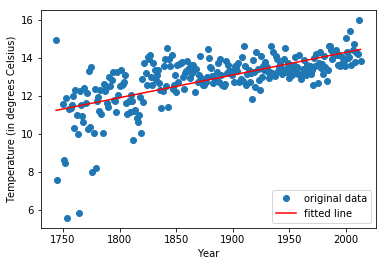

In [60]:
# linear regression plot of spring data
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.show()

### Summer Linear Regression

In [61]:
# set the variables to time and temperature for the summer
x = summer[['year']].values
y = summer[['AverageTemperature']].values

In [62]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.002217    intercept: 19.151381    r-squared: 0.060295    p-value: 0.000055


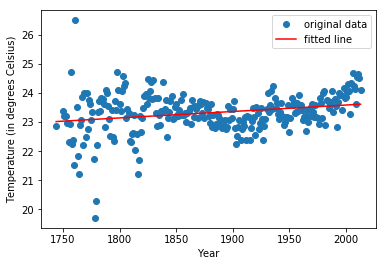

In [63]:
# linear regression plot of summer data
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.show()

### Fall Linear Regression

In [64]:
# set the variables to time and temperature for the fall
x = fall[['year']].values
y = fall[['AverageTemperature']].values

In [65]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.014792    intercept: -13.271476    r-squared: 0.544857    p-value: 0.000000


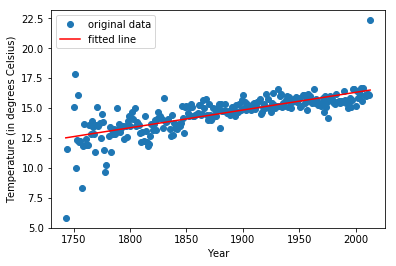

In [66]:
# linear regression plot of fall data
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.show()

## Average yearly temperature, sorted by region

In [67]:
# nine regions of the United States
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()


In [68]:
# correlation between year and average temperature for each of the regions
print('enc corr: ', enc_midwest_region['year'].corr(enc_midwest_region.AverageTemperature),'\n'
      'esc corr: ', esc_south_region['year'].corr(esc_south_region.AverageTemperature),'\n'
      'mid corr: ', mid_northeast_region['year'].corr(mid_northeast_region.AverageTemperature),'\n'
      'mt corr: ', mt_west_region['year'].corr(mt_west_region.AverageTemperature),'\n'
      'ne corr: ', ne_northeast_region['year'].corr(ne_northeast_region.AverageTemperature),'\n'
      'pac corr: ', pac_west_region['year'].corr(pac_west_region.AverageTemperature),'\n'
      'sa corr: ', sa_south_region['year'].corr(sa_south_region.AverageTemperature),'\n'
      'wnc corr: ', wnc_midwest_region['year'].corr(wnc_midwest_region.AverageTemperature),'\n'
      'wsc corr: ', wsc_south_region['year'].corr(wsc_south_region.AverageTemperature),'\n')

enc corr:  0.4030379883249252 
esc corr:  0.43415441337079186 
mid corr:  0.48081285359265274 
mt corr:  0.6734878949707309 
ne corr:  0.49294117838291945 
pac corr:  0.6427530117788472 
sa corr:  0.5347502345372169 
wnc corr:  0.5768741511922301 
wsc corr:  0.5638639630474188 



## Joined temperature and disaster data

In [69]:
joindf.head()

,Region,Disaster Type,Year,Disaster Count,AverageTemperature_mean,AverageTemperature_min,AverageTemperature_max,AverageTemperature_std,Fall,Spring,Summer,Winter
0,east north central midwest region,Fire,1953,0,11.046523,-4.808,25.870,9.009154,12.6579,9.05599,22.5851,-0.112862
1,east north central midwest region,Fire,1954,0,10.610394,-6.416,27.563,9.187059,12.1459,8.61549,22.1624,-0.48223
2,east north central midwest region,Fire,1955,0,10.504940,-6.884,27.186,10.275308,11.2949,10.6548,22.8636,-2.79356
3,east north central midwest region,Fire,1956,0,10.129736,-5.804,24.367,9.154006,11.8911,8.14903,21.6039,-1.12514
4,east north central midwest region,Fire,1957,0,10.011848,-10.172,25.552,9.295035,10.6796,9.18855,21.7707,-1.59148


In [70]:
# create key to search the join df for unique region/disaster pairs
disasters = joindf['Disaster Type'].unique()
regions = joindf['Region'].unique()

combined = [(s, f) for s in regions for f in disasters]

In [71]:
# does not exist so remove it from the keys
del combined[29]

In [72]:
# set the index to region and disaster type to search by
joindf = joindf.set_index(['Region','Disaster Type']).dropna()

In [73]:
# disaster count correlation function for each of the region-disaster pairs
def disaster_corr(key):
    X = joindf.loc[key]['AverageTemperature_mean']
    y = joindf.loc[key]['Disaster Count']
    return X.corr(y)

In [74]:
# printed list of all the region-disaster pairs
for k in combined:
    print(k, disaster_corr(k))

('east north central midwest region', 'Fire') 0.16790992751638067
('east north central midwest region', 'Flood') -0.1680062063258784
('east north central midwest region', 'Hurricane') 0.12665136949930755
('east north central midwest region', 'Storm') 0.3112142439573079
('east north central midwest region', 'Tornado') -0.06088709556578422
('east south central south region', 'Fire') 0.1999475365509537
('east south central south region', 'Flood') -0.1014460252581031
('east south central south region', 'Hurricane') 0.25810906805030676
('east south central south region', 'Storm') 0.35315426231980934
('east south central south region', 'Tornado') -0.09693352449120754
('midatlantic northeast region', 'Fire') 0.29061241936226007
('midatlantic northeast region', 'Flood') -0.18526548811148294
('midatlantic northeast region', 'Hurricane') 0.4262460858201329
('midatlantic northeast region', 'Storm') 0.3626233347910222
('midatlantic northeast region', 'Tornado') 0.07192287056899299
('mountain west 

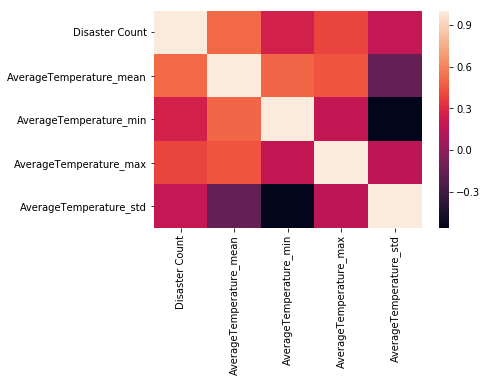

In [75]:
# correlation map for Mountain West Region / Fire
corrdf = joindf.loc[('mountain west region', 'Fire')]
corrdf = corrdf.drop(['Year'], axis=1)
corr = corrdf.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

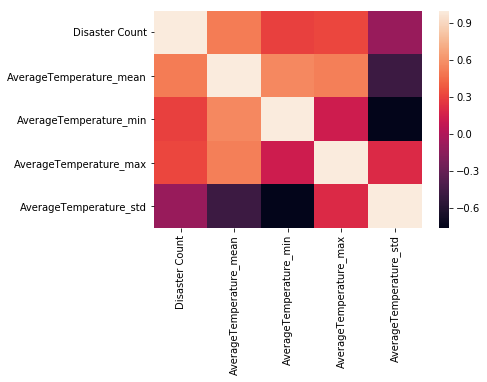

In [76]:
# correlation map for New England Northeast Region / Storm
corrdf = joindf.loc[('new england northeast region', 'Storm')]
corrdf = corrdf.drop(['Year'], axis=1)
corr = corrdf.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

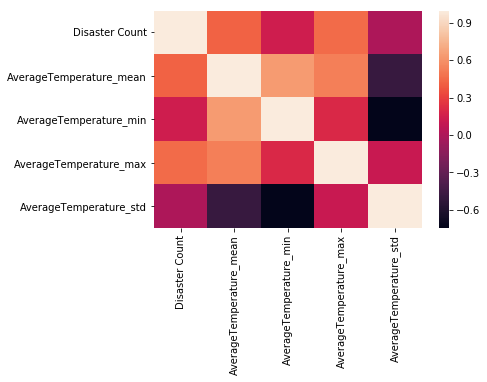

In [77]:
# correlation map for Mid Atlantic Northeast Region / Hurricane
corrdf = joindf.loc[('midatlantic northeast region', 'Hurricane')]
corrdf = corrdf.drop(['Year'], axis=1)
corr = corrdf.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Machine Learning

### Random Forest Model

In [78]:
# create features and targets for random forest model
feature_headers = joindf.drop(['Disaster Count'], axis=1).columns
target_header = 'Disaster Count'

In [79]:
# create random forest model function
def rfvalues(dataframe):
    
    # random forest regression
    X = dataframe.drop(['Disaster Count'], axis=1).values
    y = dataframe['Disaster Count'].values
    names = join_dataframe[['AverageTemperature_mean','AverageTemperature_min','AverageTemperature_max','AverageTemperature_std','Fall','Spring','Summer','Winter']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # Create the regressor: 
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

    # Fit the regressor to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_pred = rf.predict(X_test)
    
    errors = abs(y_pred - y_test)

    return('Mean Absolute Error: {}'.format(round(np.mean(errors), 2)),\
          'Root Mean Squared Error: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),\
          'R^2 or Score: {}'.format(rf.score(X_test, y_test)), \
          'Features sorted by their importance: {}'.format(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)))


In [80]:
columns = joindf.columns.drop('Disaster Count')

# linear regression to obtain independent variable predictions to use for random forest
def linearreg(key, column, year):
    X = joindf.loc[key][['Year']].values
    y = joindf.loc[key][column].values

    X = X.reshape(-1,1)
    y = y.reshape(-1,1)

    model = linear_model.LinearRegression()
    model.fit(X, y)
    
    return model.predict(year)

In [81]:
def rfmodel(x_var, key):
    
    # random forest regression
    X = joindf.loc[key].drop(['Disaster Count'], axis=1).values
    y = joindf.loc[key]['Disaster Count'].values
    names = join_dataframe[['AverageTemperature_mean','AverageTemperature_min','AverageTemperature_max','AverageTemperature_std','Fall','Spring','Summer','Winter']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # Create the regressor: 
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

    # Fit the regressor to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_var = rf.predict(X_test)
    
    return rf

### Mountain West Fires

In [82]:
# mountain west region / fire dataframe
mtw_fire_df = joindf.loc[('mountain west region','Fire')]

In [83]:
mtw_fire_df[['Year','Disaster Count']].tail(1)

,,Year,Disaster Count
Region,Disaster Type,,
mountain west region,Fire,2012,21


In [84]:
mtw_fire_df['Disaster Count'].value_counts()

0     43
1      3
21     2
12     2
8      2
39     1
22     1
20     1
18     1
17     1
9      1
5      1
3      1
Name: Disaster Count, dtype: int64

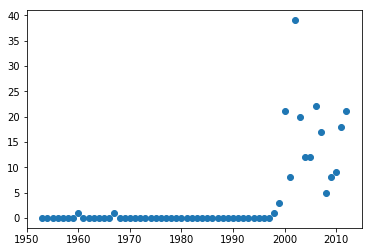

In [85]:
plt.scatter(mtw_fire_df['Year'], mtw_fire_df['Disaster Count'])

In [86]:
rfvalues(mtw_fire_df)

('Mean Absolute Error: 1.15',
 'Root Mean Squared Error: 2.06999597423119',
 'R^2 or Score: 0.8922460260788575',
 "Features sorted by their importance: [(0.4964, 'AverageTemperature_mean'), (0.3501, 'Winter'), (0.0529, 'Summer'), (0.035, 'AverageTemperature_std'), (0.0262, 'AverageTemperature_min'), (0.0143, 'AverageTemperature_max'), (0.0119, 'Fall'), (0.0092, 'Spring')]")

#### predict 2070

In [87]:
# 2070 independent variables
x_2070 = [[linearreg(('mountain west region','Fire'), col, 2070).item() for col in columns]]

In [88]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2070, ('mountain west region','Fire')).predict(x_2070)

array([23.38])

#### predict 2120

In [89]:
# 2120 independent variables
x_2120 = [[linearreg(('mountain west region','Fire'), col, 2120).item() for col in columns]]

In [90]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2120, ('mountain west region','Fire')).predict(x_2120)

array([22.88])

#### predict 2220

In [91]:
# 2220 independent variables
x_2220 = [[linearreg(('mountain west region','Fire'), col, 2220).item() for col in columns]]

In [92]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2220, ('mountain west region','Fire')).predict(x_2220)

array([23.67])

### New England Northeast Storms

In [93]:
# new england northeast region / storm dataframe
nene_storm_df = joindf.loc[('new england northeast region','Storm')]

In [94]:
nene_storm_df[['Year','Disaster Count']].tail(1)

,,Year,Disaster Count
Region,Disaster Type,,
new england northeast region,Storm,2012,3


In [95]:
nene_storm_df['Disaster Count'].value_counts()

0     40
3      5
2      5
1      4
9      2
10     1
8      1
6      1
5      1
Name: Disaster Count, dtype: int64

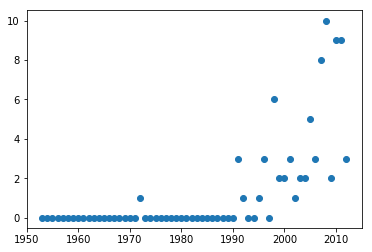

In [96]:
plt.scatter(nene_storm_df['Year'], nene_storm_df['Disaster Count'])

In [97]:
rfvalues(nene_storm_df)

('Mean Absolute Error: 1.08',
 'Root Mean Squared Error: 1.8392782400834422',
 'R^2 or Score: 0.6070010756543565',
 "Features sorted by their importance: [(0.5746, 'AverageTemperature_mean'), (0.1283, 'Spring'), (0.0895, 'AverageTemperature_min'), (0.0594, 'Summer'), (0.0481, 'AverageTemperature_max'), (0.0286, 'AverageTemperature_std'), (0.0274, 'Winter'), (0.0202, 'Fall')]")

In [98]:
# 2070 independent variables
x_2070 = [[linearreg(('new england northeast region','Storm'), col, 2070).item() for col in columns]]

In [99]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2070, ('new england northeast region','Storm')).predict(x_2070)

array([5.16])

#### predict 2120

In [100]:
# 2120 independent variables
x_2120 = [[linearreg(('new england northeast region','Storm'), col, 2120).item() for col in columns]]

In [101]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2120, ('new england northeast region','Storm')).predict(x_2120)

array([5.62])

#### predict 2220

In [102]:
# 2220 independent variables
x_2220 = [[linearreg(('new england northeast region','Storm'), col, 2220).item() for col in columns]]

In [103]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2220, ('new england northeast region','Storm')).predict(x_2220)

array([5.81])

### Midatlantic Northeast Hurricanes

In [104]:
# midatlantic northeast region / hurricane dataframe
midne_hurricane_df = joindf.loc[('midatlantic northeast region','Hurricane')] 

In [105]:
midne_hurricane_df[['Year','Disaster Count']].tail(1)

,,Year,Disaster Count
Region,Disaster Type,,
midatlantic northeast region,Hurricane,2012,5


In [106]:
midne_hurricane_df['Disaster Count'].value_counts()

0    50
1     4
5     2
3     2
6     1
2     1
Name: Disaster Count, dtype: int64

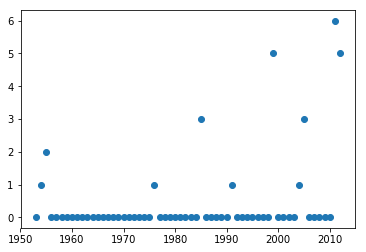

In [107]:
plt.scatter(midne_hurricane_df['Year'], midne_hurricane_df['Disaster Count'])

In [108]:
rfvalues(midne_hurricane_df)

('Mean Absolute Error: 0.78',
 'Root Mean Squared Error: 1.2617954579795323',
 'R^2 or Score: 0.05866897810218974',
 "Features sorted by their importance: [(0.3587, 'AverageTemperature_mean'), (0.1834, 'Summer'), (0.1333, 'AverageTemperature_std'), (0.1095, 'Spring'), (0.1002, 'Winter'), (0.0697, 'AverageTemperature_min'), (0.0174, 'AverageTemperature_max'), (0.0134, 'Fall')]")

In [109]:
# 2070 independent variables
x_2070 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2070).item() for col in columns]]

In [110]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2070, ('midatlantic northeast region','Hurricane')).predict(x_2070)

array([4.37])

#### predict 2120

In [111]:
# 2120 independent variables
x_2120 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2120).item() for col in columns]]

In [112]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2120, ('midatlantic northeast region','Hurricane')).predict(x_2120)

array([4.5])

#### predict 2220

In [113]:
# 2220 independent variables
x_2220 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2220).item() for col in columns]]

In [114]:
# random forest using predicted independent variables to predict disaster counts
rfmodel(x_2220, ('midatlantic northeast region','Hurricane')).predict(x_2220)

array([4.64])

### Linear Regression Model

In [115]:
# train and test data for modeling
def lrvalues(key):
    X = joindf.loc[key].drop(['Disaster Count'], axis=1).values
    y = joindf.loc[key]['Disaster Count'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    
    y_pred = lm.predict(X_test)
    
    errors = abs(y_pred - y_test)
    
    return ('Mean Absolute Error: {}'.format(round(np.mean(errors), 2)), \
            'Root Mean Squared Error: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),\
            'R^2 (Score): {}'.format(lm.score(X_test, y_test)))

In [116]:
# train and test data for modeling
def lrmodel(key):
    X = joindf.loc[key].drop(['Disaster Count'], axis=1).values
    y = joindf.loc[key]['Disaster Count'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    lm = linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    
    y_pred = lm.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return lm



### Mountain West Fires

In [117]:
# linear regression score and mean absolute error for mountain west fires
lrvalues(('mountain west region', 'Fire'))

('Mean Absolute Error: 3.39',
 'Root Mean Squared Error: 4.457284192152718',
 'R^2 (Score): 0.5003856032478187')

#### predict 2070

In [118]:
# 2070 independent variables
x_2070 = [[linearreg(('mountain west region', 'Fire'), col, 2070).item() for col in columns]]

In [119]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('mountain west region', 'Fire')).predict(x_2070)

array([27.52380952])

#### predict 2120

In [120]:
# 2120 independent variables
x_2120 = [[linearreg(('mountain west region', 'Fire'), col, 2120).item() for col in columns]]

In [121]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('mountain west region', 'Fire')).predict(x_2120)

array([41.27380952])

#### predict 2220

In [122]:
# 2220 independent variables
x_2220 = [[linearreg(('mountain west region', 'Fire'), col, 2220).item() for col in columns]]

In [123]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('mountain west region', 'Fire')).predict(x_2220)

array([68.52380952])

### New England Northeast Storms

In [124]:
# linear regression score and mean absolute error for new england northeast storms
lrvalues(('new england northeast region','Storm'))

('Mean Absolute Error: 1.28',
 'Root Mean Squared Error: 1.6856783686450658',
 'R^2 (Score): 0.6698996965737553')

#### predict 2070

In [125]:
# 2070 independent variables
x_2070 = [[linearreg(('new england northeast region','Storm'), col, 2070).item() for col in columns]]

In [126]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('new england northeast region','Storm')).predict(x_2070)

array([8.41801329])

#### predict 2120

In [127]:
# 2120 independent variables
x_2120 = [[linearreg(('new england northeast region','Storm'), col, 2120).item() for col in columns]]

In [128]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('new england northeast region','Storm')).predict(x_2120)

array([12.5841627])

#### predict 2220

In [129]:
# 2220 independent variables
x_2220 = [[linearreg(('new england northeast region','Storm'), col, 2220).item() for col in columns]]

In [130]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('new england northeast region','Storm')).predict(x_2220)

array([20.91646151])

###  Midatlantic Northeast Hurricanes

In [131]:
# linear regression score and mean absolute error for midatlantic northeast hurricanes
lrvalues(('midatlantic northeast region','Hurricane'))

('Mean Absolute Error: 1.26',
 'Root Mean Squared Error: 1.6248727506103424',
 'R^2 (Score): -0.5610009336478659')

#### predict 2070

In [132]:
# 2070 independent variables
x_2070 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2070).item() for col in columns]]

In [133]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('midatlantic northeast region','Hurricane')).predict(x_2070)

array([2.78869048])

#### predict 2120

In [134]:
# 2120 independent variables
x_2120 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2120).item() for col in columns]]

In [135]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('midatlantic northeast region','Hurricane')).predict(x_2120)

array([4.05431548])

#### predict 2220

In [136]:
# 2220 independent variables
x_2220 = [[linearreg(('midatlantic northeast region','Hurricane'), col, 2220).item() for col in columns]]

In [137]:
# random forest using predicted independent variables to predict disaster counts
lrmodel(('midatlantic northeast region','Hurricane')).predict(x_2220)

array([6.60119048])

### Cross Validation

In [148]:
from sklearn.model_selection import KFold
X = joindf.loc[('midatlantic northeast region','Hurricane')].drop(['Disaster Count'], axis=1).values
y = joindf.loc[('midatlantic northeast region','Hurricane')]['Disaster Count'].values
    
kf = KFold(n_splits=10, random_state=42, shuffle=True)



In [149]:
from sklearn.cross_validation import KFold, cross_val_score, cross_val_predict

lm = linear_model.LinearRegression()

score = cross_val_score(lm, X, y, cv=kf.split(X), n_jobs=1)
y_pred = cross_val_predict(lm, X, y, cv=kf.split(X))
rsquared = metrics.r2_score(y,y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(rsquared)

-0.030345438625613674


In [150]:
lm = linear_model.LinearRegression()
score = cross_val_score(lm, X, y, cv=kf.split(X), n_jobs=1).mean()
print(score)

-0.7794925655304441
